In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from network.styler import Unet
from loss.loss import CLIPLoss
from utils.func import get_features,vgg_normalize

import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lr1 = 0.001
lr2 = 0.0003
# lr_fast = 0.0002
# lr_slow = 0.00005

# model = Unet(device).to(device)
model = Unet().to(device)
cliploss = CLIPLoss(device)
mseloss = torch.nn.MSELoss()
# vgg = torchvision.models.vgg19(pretrained=True).features.to(device)
# for x in vgg.parameters():
#     x.requires_grad = False

topil = transforms.ToPILImage()
topic = transforms.ToTensor()

dir_lambda = 500
content_lambda = 150
patch_lambda = 9000
norm_lambda = 0.002
gol_lambda = 300

In [3]:
file_u = open("neo.txt", "r")
loss_li = file_u.readline()
loss_li = [float(x) for x in loss_li.split()]
if not loss_li:
    loss_li = [0]*100

cur_times = int(file_u.readline())


In [4]:
def train(iteration1, iteration2, pic, source, target):
    input = pic

    # pic_f = get_features(vgg_normalize(pic), vgg)
    # print(model.parameters())
    opt = optim.Adam(model.parameters(), lr=lr1)
    for i in range(iteration1):
        opt.zero_grad()
        neo_pic = model(input)
        loss = mseloss(pic, neo_pic) * 1

        # loss = 0
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        loss.backward()
        opt.step()

        print("iter:", i + 1, "loss:", loss.item())

        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 50) == 0:
        #     pil.save(f"./pic1/{(i + 1) // 50}.jpg")
    # neo_pic = model(input)
    # pil = topil(neo_pic.squeeze(0).cpu())
    # # pil.save(f"{source}-{target}.jpg")
    # pil.save(path)


    # torch.save(model,'unet.pth')

    # model = torch.load('unet.pth')

    # pic_f = get_features(vgg_normalize(pic),vgg)

    opt = optim.Adam(model.parameters(), lr=lr2)
    # opt_fast = optim.Adam(model.parameters(), lr=lr2)
    # opt_slow = optim.Adam(model.parameters(), lr=lr_fast)
    # opt_loss = optim.Adam(cliploss.parameters(), lr=lr_slow)
    for i in range(iteration2):


        opt.zero_grad()
        # opt_slow.zero_grad()
        # opt_fast.zero_grad()

        neo_pic = model(input)

        dir_loss = 0
        dir_loss += cliploss.forward_dir(pic, source, neo_pic, target)

        gol_loss = 0
        gol_loss += cliploss.forward_gol(pic, source, neo_pic, target)

        content_loss = 0
        # content_loss += mseloss(pic, neo_pic)
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # content_loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # content_loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        patch_loss = 0
        patch_loss += cliploss.forward_patch(pic, source, neo_pic, target)

        norm_loss = 0
        norm_loss += cliploss.forward_prior(pic, source, neo_pic, target)

        loss = dir_loss * dir_lambda + \
               content_loss * content_lambda + \
               patch_loss * patch_lambda + \
               norm_loss * norm_lambda + \
               gol_loss * gol_lambda



        # patch_loss_fast,patch_loss_slow = cliploss.forward_patch_sec(pic, source, neo_pic, target)
        # patch_loss_fast.backward(retain_graph=True)
        # patch_loss_slow.backward(retain_graph=True)


        loss.backward()
        opt.step()

        # opt_fast.step()
        # opt_slow.step()

        loss_li[i]+=(loss.item())

        print("iter:", i + 1, "loss:", loss.item())


        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 10) == 0:
        #     pil.save(f"./pic2/{(i + 1) // 10}.jpg")

    # return  model(input)
    # neo_pic = model(input)
    # pil = topil(neo_pic.squeeze(0).cpu())
    # # pil.save(f"{source}-{target}.jpg")
    # pil.save(path)


In [5]:
pil = Image.open(f"./source_pic/church.jpeg")
ori_size = pil.size[::-1]
pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)
pic = topic(pil).unsqueeze(0).to(device)
# pic = torch.ones(1, 3, 512, 512).to(device)
pic.requires_grad = False

source = "photo"
# source = "white shirt"
# source = "man"
# source = "anime"

target = "Neon light"
# target = "mosaic"
# target = "Van gogh"
# target = "Japanese anime"
# target = "woman"
# target = "fire"
# target = "white wool"
# target = "black suit"
# target = "sketch"
# target = "pop art of night city"
# target = "starry night by Van Gogh"
# target = "the scream by Edvard Munch"
# target = "Chinese Ink and wash painting"
# target = "The great wave off kanagawa by Hokusai"

path = "result/result12.jpg"

C:\Users\win10\AppData\Local\Temp\ipykernel_22088\2756271223.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)
E:\Anaconda\envs\sth\lib\site-packages\torchvision\transforms\transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [6]:
start = time.time()
train(100, 100, pic, source, target)
end = time.time()
usetime = end - start
print(f"usetime: {usetime}")

iter: 1 loss: 0.07340855896472931
iter: 2 loss: 0.05391133949160576
iter: 3 loss: 0.043905165046453476
iter: 4 loss: 0.03601022809743881
iter: 5 loss: 0.030195316299796104
iter: 6 loss: 0.025409197434782982
iter: 7 loss: 0.021110013127326965
iter: 8 loss: 0.016851775348186493
iter: 9 loss: 0.013224242255091667
iter: 10 loss: 0.010769840329885483
iter: 11 loss: 0.009750636294484138
iter: 12 loss: 0.00953952968120575
iter: 13 loss: 0.00889904797077179
iter: 14 loss: 0.008024787530303001
iter: 15 loss: 0.007071535103023052
iter: 16 loss: 0.006193429231643677
iter: 17 loss: 0.005799082573503256
iter: 18 loss: 0.005585066042840481
iter: 19 loss: 0.005421490874141455
iter: 20 loss: 0.0051994482055306435
iter: 21 loss: 0.004908179398626089
iter: 22 loss: 0.004597598686814308
iter: 23 loss: 0.004309989511966705
iter: 24 loss: 0.004078993108123541
iter: 25 loss: 0.0038994960486888885
iter: 26 loss: 0.003753600176423788
iter: 27 loss: 0.0036396170035004616
iter: 28 loss: 0.0035334404092282057
it

In [7]:
neo_pic = model(pic)
pil = topil(neo_pic.squeeze(0).cpu())
pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)
pil.save(path)



# 186.4968602657318


C:\Users\win10\AppData\Local\Temp\ipykernel_22088\3060622835.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)


In [8]:
# with open(file = "neo.txt", mode = "w") as file:
#     for i in loss_li:
#         file.write(str(i)+" ")
#     file.write("\n")
#     file.write(str(cur_times+1))


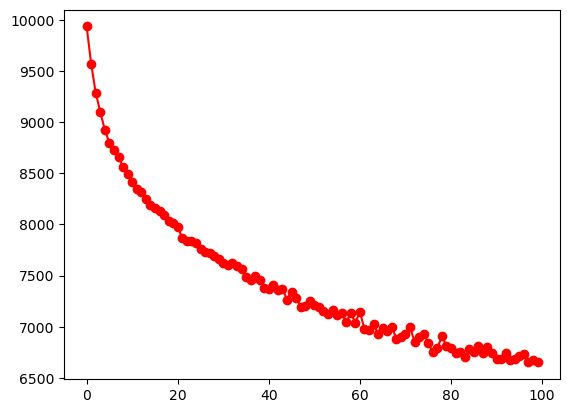

In [9]:
import matplotlib.pyplot as plt

x = [i for i in range(100)]
loss_li = [x/(cur_times+1) for x in loss_li]
plt.plot(x,loss_li,color="red",marker="o")


